<a name='1'></a>
## 1 - Packages

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
from resnets_utils import *


%matplotlib inline

 
  Functional API to create a shortcut path: 

In [2]:
# 
# FUNCTION 1: identity_block

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [3]:

# FUNCTION 2: convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s),padding = 'valid',kernel_initializer = initializer(seed = 0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)
    
    

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [4]:

# FUNCTION 3 : ResNet18

def ResNet18(input_shape = (64,64,3), classes = 6):
    """

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 2))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)  #Layer 3
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3,[64,64,256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512]) 
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    

    ## Stage 5 (≈3 lines)
    
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048]) 
    X = Dropout(0.5)(X)
    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (1,1), name = 'avg_pool')(X) 
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [5]:
model = ResNet18(input_shape = (64,64,3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 68, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 31, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 31, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

As shown in the Keras Tutorial Notebook, prior to training a model, you need to configure the learning process by compiling the model.

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model is now ready to be trained. The only thing you need now is a dataset!

In [7]:

X_train_orig, Y_train_orig,X_test_orig, Y_test_orig, classes = load_dataset()
#(X_train_orig, Y_train_orig),(X_test_orig, Y_test_orig) = cifar10.load_data()
# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Epoch 1/20
31/31 [==============================] - 14s 70ms/step - loss: 3.9184 - accuracy: 0.2942 - val_loss: 2.0025 - val_accuracy: 0.3519
Epoch 2/20
31/31 [==============================] - 1s 40ms/step - loss: 2.7588 - accuracy: 0.4280 - val_loss: 2.6845 - val_accuracy: 0.3333
Epoch 3/20
31/31 [==============================] - 1s 40ms/step - loss: 2.0623 - accuracy: 0.4856 - val_loss: 1.7108 - val_accuracy: 0.3611
Epoch 4/20
31/31 [==============================] - 1s 40ms/step - loss: 1.6760 - accuracy: 0.5535 - val_loss: 1.6658 - val_accuracy: 0.4815
Epoch 5/20
31/31 [==============================] - 1s 41ms/step - loss: 1.7362 - accuracy: 0.5391 - val_loss: 1.8234 - val_accuracy: 0.4074
Epoch 6/20
31/31 [==============================] - 1s 40ms/step - loss: 1.3552 - accuracy: 0.5669 - val_loss: 1.7053 - val_accuracy: 0.5463
Epoch 7/20
31/31 [==============================] - 1s 40ms/step - loss: 1.2572 - accuracy: 0.6132 - val_loss: 1.9938 - val_accuracy: 0.4167
Epoch 8/20
3

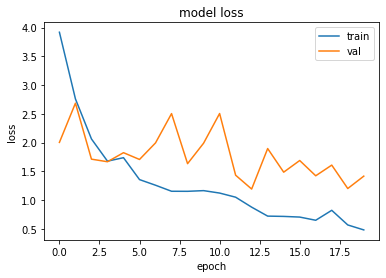

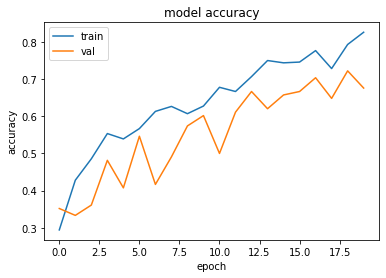

In [8]:
history = model.fit(X_train, Y_train, epochs = 20, validation_split = 0.1, batch_size = 32)
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'best')
plt.savefig('resnet18_1_loss.pdf')
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'best')
plt.savefig('resnet18_1_accuracy.pdf')
plt.show()

Let's see how this model (trained on only two epochs) performs on the test set.

In [10]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 0s 14ms/step - loss: 1.2162 - accuracy: 0.7083
Loss = 1.216235876083374
Test Accuracy = 0.7083333134651184
